# Distribution learning on MOSES dataset

Run `moses_prepare_metrics.ipynb` first to reproduce the experiments. This notebook will plot the final results.

In [1]:
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

%matplotlib inline

In [2]:
all_metrics = {}
plots = {}
for path in glob.glob('metrics/*/*.pkl'):
    epoch_id = int(path.split('/')[-1][:-4])
    config_id = path.split('/')[1]
    with open(path, 'rb') as f:
        if config_id not in plots:
            plots[config_id] = []
        data = pickle.load(f)
        data['epoch'] = epoch_id
        plots[config_id].append(data)

In [3]:
def retrieve_stats(plot_name, label):
    data = plots[plot_name]
    if label in data[0]:
        stats = [(t['epoch'], t[label]) for t in data]
        stats = sorted(stats)
        total_epochs = max([x[0] for x in stats])
        stats_full = np.zeros(total_epochs) * np.nan
        for epoch, value in stats:
            stats_full[epoch-1] = value
        return np.array(stats_full)
    else:
        path = glob.glob(f'logs/moses/{plot_name}/*')
        if len(path) == 0:
            print('No logs for ', plot_name)
            return
        path = path[0]
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        return np.array(pd.DataFrame(event_acc.Scalars(label))['value'].values)

In [4]:
experiments = [
    [
        'VAE_gaussian_seed1',
        'VAE_gaussian_seed2',
        'VAE_gaussian_seed3',
    ], [
        'VAE_triweight_seed1',
        'VAE_triweight_seed2',
        'VAE_triweight_seed3',
    ], [
        'DD-VAE_gaussian_seed1',
        'DD-VAE_gaussian_seed2',
        'DD-VAE_gaussian_seed3',
    ], [
        'DD-VAE_triweight_seed1',
        'DD-VAE_triweight_seed2',
        'DD-VAE_triweight_seed3',
    ]
]

labels = ['VAE, Gaussian', 'VAE, Triweight', 'DD-VAE, Gaussian', 'DD-VAE, Triweight']

In [5]:
def build(plot_names, x_label='string_accuracy/test',
          y_label='FCD/Test', skip=20, w=0.01,
          xlim=None, label=None, mode='-',
          points=1000, c='r', log=False):
    data_x = []
    data_y = []
    for plot_name in plot_names:
        x_values = retrieve_stats(plot_name, x_label)[skip:]
        y_values = retrieve_stats(plot_name, y_label)[skip:]
        min_len = min(len(x_values), len(y_values))
        x_values = x_values[:min_len]
        y_values = y_values[:min_len]
        data_x.append(x_values)
        data_y.append(y_values)
    xlim = xlim or (0, 1)
    x_span = np.linspace(xlim[0], xlim[1], points)
    y_mean = []
    y_std = []
    for x in x_span:
        y_values = []
        for plot_x, plot_y in zip(data_x, data_y):
            x_idx = (plot_x < x + w) & (plot_x > x - w)
            k = 1 - np.abs(plot_x[x_idx]-x) / w
            value = (plot_y[x_idx] * k).sum() / k.sum()
            y_values.append(value)
        y_mean.append(np.mean(y_values))
        y_std.append(np.std(y_values))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)
    label = label or f'{plot_names[0]} ({len(x)})'
    if log:
        for i in range(len(x_span)):
            print(fr"{x_span[i]}, {y_mean[i]:.3f} $\pm$ {y_std[i]:.3f}")
        print(x_span, y_mean, y_std)
    plt.plot(x_span, y_mean, '-', c=c, linewidth=1, label=label)
    plt.fill_between(x_span, y_mean-y_std, y_mean+y_std,
                     alpha=0.4, color=c, linewidth=0)

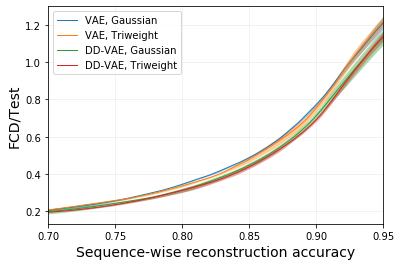

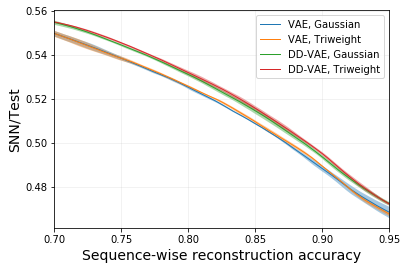

In [6]:
xlabel = 'string_accuracy/test'
xlim = (0.7, 0.95)

for ylabel in ['FCD/Test', 'SNN/Test']:
    plt.figure()
    plt.xlabel('Sequence-wise reconstruction accuracy', fontsize=14)
    colors = [x['color'] for x in matplotlib.rcParams['axes.prop_cycle']]
    for i in range(len(experiments)):
        build(experiments[i], xlabel, ylabel,
              xlim=xlim, label=labels[i], w=0.05,
              c=colors[i])
    plt.xlim(xlim)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(alpha=0.2)
    plt.legend()
    caption = ylabel.split('/')[0]
    plt.savefig(f'images/moses_{caption}.pdf')
    plt.show()